# EDA TRM


In [496]:
import pandas as pd
from azure.data.tables import TableClient
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy.stats import kurtosis, skew

In [497]:
load_dotenv(find_dotenv())

True

In [498]:
connection_string = os.getenv("AZ_CONNECTION_STRING")

Funciones necesarias


In [499]:
## Definiendo funciones:


# Crear conexión de una tabla específica dentro del servicio de Azure Table Storage
def set_table_service(connection_string, table):
    """Crear servicio de conexión a Azure Table Storage"""
    return TableClient.from_connection_string(
        conn_str=connection_string, table_name=table
    )


# Obtener datos de Table Storage
def get_data_from_table_storage_table(table_service, filter_query):
    """Recuperar datos de Table Storage"""
    for record in table_service.query_entities(filter_query):
        yield record


# Crear DataFrame con los datos de la tabla consultada
def get_dataframe_from_table_storage_table(table_service, filter_query):
    """Crear un DataFrame con la data del Table Storage"""
    return pd.DataFrame(get_data_from_table_storage_table(table_service, filter_query))

In [500]:
table_name_trm = "TRMCurated"
filterQuery = "PartitionKey ne 'random'"

In [501]:
# Creando DataFrame con TRM Data
table_service_trm = set_table_service(connection_string, table_name_trm)
df_trm = get_dataframe_from_table_storage_table(table_service_trm, filterQuery)

print(f"Shape: {df_trm.shape}")
print(f"dtypes: {df_trm.dtypes}")
df_trm.head()

Shape: (689, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05T00:00:00.000,2021-01-05T00:00:00.000
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06T00:00:00.000,2021-01-06T00:00:00.000
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07T00:00:00.000,2021-01-07T00:00:00.000
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08T00:00:00.000,2021-01-08T00:00:00.000
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09T00:00:00.000,2021-01-12T00:00:00.000


In [502]:
conteo_por_grupo = df_trm.groupby(["vigenciadesde"]).size().reset_index(name="Conteo")

# Muestra los grupos que tienen más de un registro (si hay alguno)
duplicados = conteo_por_grupo[conteo_por_grupo["Conteo"] > 1]

In [503]:
duplicados.head()

,vigenciadesde,Conteo
666,2023-10-24T00:00:00.000,2
675,2023-11-04T00:00:00.000,2


In [504]:
duplicados = df_trm[df_trm.duplicated()]

# Si hay registros duplicados, verifica que todos tengan el mismo valor en 'Valor'
for indice, grupo in duplicados.groupby(["vigenciadesde", "vigenciahasta"]):
    if grupo["Valor"].nunique() > 1:
        print(
            f"Registros duplicados con diferentes valores en 'Valor' para Departamento {indice[0]} y Fecha {indice[1]}:"
        )
        print(grupo)

# todos los registros duplicados tienen el mismo valor

In [505]:
# Borramos los duplicados que TRM

df_sin_duplicados = df_trm.drop_duplicates(
    subset=["valor", "vigenciadesde", "vigenciahasta"]
)

# Imprime el DataFrame resultante
print(f"Shape: {df_sin_duplicados.shape}")
print(f"dtypes: {df_sin_duplicados.dtypes}")
df_sin_duplicados.head()

Shape: (687, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05T00:00:00.000,2021-01-05T00:00:00.000
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06T00:00:00.000,2021-01-06T00:00:00.000
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07T00:00:00.000,2021-01-07T00:00:00.000
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08T00:00:00.000,2021-01-08T00:00:00.000
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09T00:00:00.000,2021-01-12T00:00:00.000


In [506]:
# Se organiza la fecha con el formato necesario

df_sin_duplicados_fecha = df_sin_duplicados.copy()

df_sin_duplicados_fecha["vigenciadesde"] = pd.to_datetime(
    df_sin_duplicados_fecha["vigenciadesde"], errors="coerce"
)
df_sin_duplicados_fecha["vigenciadesde"] = df_sin_duplicados_fecha[
    "vigenciadesde"
].dt.strftime("%Y-%m-%d")
df_sin_duplicados_fecha["vigenciahasta"] = pd.to_datetime(
    df_sin_duplicados_fecha["vigenciahasta"], errors="coerce"
)
df_sin_duplicados_fecha["vigenciahasta"] = df_sin_duplicados_fecha[
    "vigenciahasta"
].dt.strftime("%Y-%m-%d")

print(f"Shape: {df_sin_duplicados_fecha.shape}")
print(f"dtypes: {df_sin_duplicados_fecha.dtypes}")
df_sin_duplicados_fecha

Shape: (687, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05,2021-01-05
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06,2021-01-06
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07,2021-01-07
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08,2021-01-08
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09,2021-01-12
...,...,...,...,...,...
684,TRM_20231117.csv,2023-11-17T00:00:00.000,4077.44,2023-11-17,2023-11-17
685,TRM_20231118.csv,2023-11-18T00:00:00.000,4116.59,2023-11-18,2023-11-20
686,TRM_20231121.csv,2023-11-21T00:00:00.000,4033.83,2023-11-21,2023-11-21
687,TRM_20231122.csv,2023-11-22T00:00:00.000,4060.15,2023-11-22,2023-11-22


In [507]:
df = df_sin_duplicados_fecha[["vigenciadesde", "valor"]]

In [508]:
df.isnull()

,vigenciadesde,valor
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
684,False,False
685,False,False
686,False,False
687,False,False


In [509]:
# Verifica si hay algún True en la columna vigenciadesde
hay_datos_nulos_vigenciadesde = any(df.isnull()["vigenciadesde"])

# Verifica si hay algún True en la columna valor
hay_datos_nulos_valor = any(df.isnull()["valor"])

print(hay_datos_nulos_vigenciadesde, hay_datos_nulos_valor)

True False


In [510]:
null_indices = df[df["vigenciadesde"].isnull()].index.tolist()

# Imprimimos el índice que tiene un valor de NaN en la fecha
print(null_indices)

[674]


Más abajo, haremos una "reindexación" de las fechas para arreglar este problema.


In [511]:
print(f"dtypes: {df.dtypes}")

dtypes: vigenciadesde     object
valor            float64
dtype: object


In [512]:
df["vigenciadesde"] = pd.to_datetime(df["vigenciadesde"])

/tmp/ipykernel_617708/2710564580.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687 entries, 0 to 688
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   vigenciadesde  686 non-null    datetime64[ns]
 1   valor          687 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.1 KB


In [514]:
# Obtiene las estadísticas básicas de los datos
df["valor"].describe()

count     687.000000
mean     4111.860684
std       400.704113
min      3420.780000
25%      3797.600000
50%      3997.740000
75%      4421.760000
max      5061.210000
Name: valor, dtype: float64

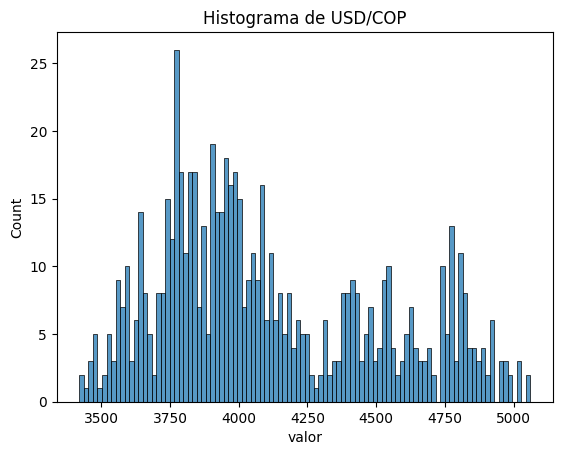

In [515]:
sns.histplot(df["valor"], bins=100, linewidth=0.5)
plt.title("Histograma de USD/COP")
plt.show()

Los datos de la TRM siguen una distribución bimodal. Vamos a calcular la kurtosis y la asimetría.


In [525]:
# Calculate kurtosis
kurtosis_value = kurtosis(
    df["valor"], fisher=False
)

# Calculate skewness
skewness_value = skew(df["valor"])

print(f"Kurtosis: {kurtosis_value}")
print(f"Skewness: {skewness_value}")

Kurtosis: 2.20733334068744
Skewness: 0.5479653446237988


La kurtosis es menor a 2, lo que indica que la distribución es más achatada que la distribución normal y la asimetría es ligeramente positiva, indicando una tendencia de la distribución a tener una cola pesada a la derecha.

In [517]:
df["year"] = df["vigenciadesde"].dt.year
df_agrupado = df.groupby("year")
df.groupby("year")["valor"].describe()

/tmp/ipykernel_617708/854676413.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2021.0,238.0,3749.122437,145.569419,3420.78,3636.4225,3768.460,3854.565,4023.68
2022.0,238.0,4251.469664,387.652758,3706.95,3934.0425,4140.540,4528.965,5061.21
2023.0,210.0,4364.712667,310.338101,3898.48,4092.5075,4249.355,4644.320,4989.58


In [518]:
def graph_trm_time_series():
    # Graficar el comportamiento por año
    fig = go.Figure()

    # Add a trace for each year
    for year, color in zip([2021, 2022, 2023], ["red", "orange", "blue"]):
        # Filter the DataFrame for the year
        df_year = df[df["year"] == year]

        # Add a trace for this year
        fig.add_trace(
            go.Scatter(
                x=df_year["vigenciadesde"],
                y=df_year["valor"],
                mode="lines",
                name=str(year),
                line=dict(color=color),
            )
        )

    # Update layout
    fig.update_layout(title="TRM por año")

    # Show the plot
    fig.show()

In [519]:
graph_trm_time_series()

Vemos que hay datos faltantes a inicios del año 2022 y a inicios del año 2023. Por ende, se procede a hacer una imputación utilizando el método de "Forward Fill".


In [520]:
# Set 'vigenciadesde' as the index
df.set_index("vigenciadesde", inplace=True)

# Create a complete date range
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame
df = df.reindex(full_date_range)

# Choose an imputation method, for example, forward fill
df.ffill(inplace=True)

# Reset the index if needed
df.reset_index(inplace=True)
df.rename(columns={"index": "vigenciadesde"}, inplace=True)
df.head()

,vigenciadesde,valor,year
0,2021-01-05,3420.78,2021.0
1,2021-01-06,3450.74,2021.0
2,2021-01-07,3428.04,2021.0
3,2021-01-08,3459.39,2021.0
4,2021-01-09,3478.11,2021.0


In [521]:
graph_trm_time_series()

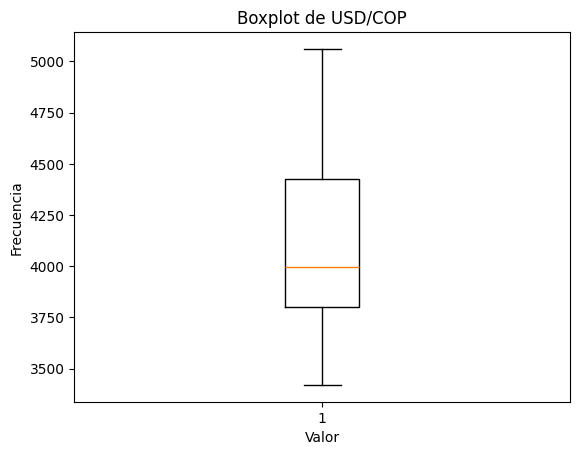

In [522]:
fig, ax = plt.subplots()

ax.boxplot(df["valor"], whis=1.5, showfliers=True)

ax.set_xlabel("Valor")

ax.set_ylabel("Frecuencia")

ax.annotate("Valor atípico", (df["valor"].min(), 0.5))

plt.title("Boxplot de USD/COP")

plt.show()

In [523]:
TRM = df[["vigenciadesde", "valor"]]

In [524]:
# Establecer la ruta del archivo CSV
ruta_archivo = "./processed_tables/TRM.csv"

# Guardar el DataFrame en el archivo CSV
TRM.to_csv(ruta_archivo, index=False)